**Context**

To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the [VIGIA project](https://jivg.org/research-projects/vigia/), which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

**Provided data description**

This dataset contains a large number of 32 x 32 thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo). Kaggle has resized the images from the original dataset to make them uniform in size. The file name of an image corresponds to its id.

I will be using the fastai library for doing my experiments. I will be approaching the problem with a deep-learning based solution.

### Installation and imports

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# list out the available files in the input path
import os
print(os.listdir("../input"))

['test', 'train', 'train.csv', 'sample_submission.csv']


In [3]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 42kB/s s eta 0:00:01   |█▉                              | 19.9MB 9.9MB/s eta 0:00:34     |████████████                    | 131.1MB 45.1MB/s eta 0:00:05     |████████████▍                   | 135.3MB 8.2MB/s eta 0:00:27
     |████████████████████████████████| 501kB 29.3MB/s eta 0:00:01
     |████████████████████████████████| 3.1MB 26kB/s eta 0:00:0101     |████                            | 399kB 30.9MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!pip install -q tensorflow_hub

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
print(tf.__version__)

2.0.0-beta1


### Loading in the data files

In [6]:
train_dir="../input/train/train"
test_dir="../input/test/test"
train = pd.read_csv('../input/train.csv')
sub_file = pd.read_csv("../input/sample_submission.csv")
data_folder = "../input"

In [7]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
sub_file.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


A utility function to show 10 randomly selected images from the provided data split.

In [9]:
def show_images(directory, df, is_train=True):
    plt.figure(figsize=(15,15))
    for i in range(10):
        n = np.random.choice(df.shape[0], 1)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        image = plt.imread(os.path.join(directory, df["id"][int(n)]))
        plt.imshow(image)
        if is_train:
            label = df["has_cactus"][int(n)]
            plt.xlabel(label)
    plt.show()


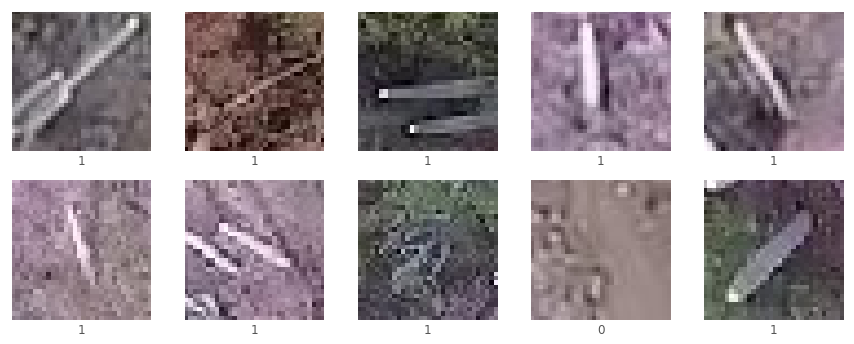

In [10]:
# train set
show_images(train_dir, train)

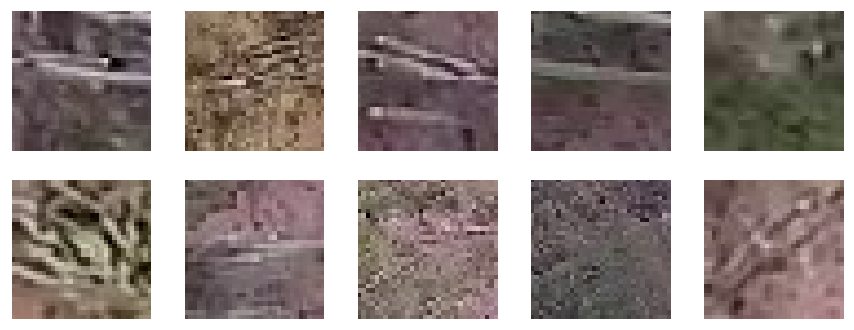

In [11]:
# test set
show_images(test_dir, sub_file, is_train=False)

Let's check out the class distribution in the train set. 

In [12]:
train["has_cactus"].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

As we can see above, there is a class imabalance & we will handle this accordingly while training our model. We now split the available training set into additional training and validation sets.

In [13]:
# 90% for train
partial_train = train.sample(frac=0.9)
train.drop(partial_train.index, axis=0, inplace=True)

# 10% for validation
valid = train

Let's check the class distributions in these two newly created splits. 

In [14]:
partial_train["has_cactus"].value_counts()

1    11814
0     3936
Name: has_cactus, dtype: int64

In [15]:
valid["has_cactus"].value_counts()

1    1322
0     428
Name: has_cactus, dtype: int64

In [16]:
# account for skew in the labeled data
lb = LabelBinarizer()
y_train = lb.fit_transform(partial_train["has_cactus"])
classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

### Data augmentation set up

In [17]:
# convert the data-type of the labels to string to make it compatible with
# ImageDataGenerator
partial_train["has_cactus"] = partial_train["has_cactus"].astype("str") 
valid["has_cactus"] = valid["has_cactus"].astype("str") 
sub_file["has_cactus"] = sub_file["has_cactus"].astype("str")

In [18]:
# set up the data augmentation objects
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(
  horizontal_flip=True,
  fill_mode="nearest")

valAug = tf.keras.preprocessing.image.ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

trainGen = trainAug.flow_from_dataframe(partial_train, directory=train_dir, 
    x_col="id", y_col="has_cactus", target_size=(224, 224), 
    class_mode="categorical", batch_size=64, shuffle=True)

valGen = valAug.flow_from_dataframe(valid, directory=train_dir, 
    x_col="id", y_col="has_cactus", target_size=(224, 224), 
    class_mode="categorical", batch_size=64)

testGen = valAug.flow_from_dataframe(sub_file, directory=test_dir, 
    x_col="id", y_col="has_cactus", target_size=(224, 224), 
    class_mode="categorical", batch_size=64)

Found 15750 validated image filenames belonging to 2 classes.
Found 1750 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 1 classes.


### Transfer learning using `TF-Hub`

We start by downloading the headless MobileNetV2 model without its classification head. This model was trained on the ImageNet dataset.

In [19]:
# define the input dimension of the KerasLayer and then set its layers to
# trainable to adapt to our dataset
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_extractor_layer.trainable = True

Let's now use the `Sequential` API of Keras to add a dense layer on top of the feature extraction layer. 

In [20]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(2, activation="sigmoid")
])

We now compile the model supplying the optimizer, loss function and the metrics we are interested in. 

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

### Model training

In [22]:
H = model.fit_generator(
    trainGen,
    steps_per_epoch=partial_train.shape[0] // 64,
    validation_data=valGen,
    validation_steps=valid.shape[0] // 64,
    epochs=5,
    class_weight=classWeight,
    verbose=1)

Epoch 1/5
246/246 [==============================] - 368s 1s/step - loss: 0.1386 - acc: 0.9826 - val_loss: 1.3884 - val_acc: 0.7321
Epoch 2/5
246/246 [==============================] - 305s 1s/step - loss: 0.1029 - acc: 0.9938 - val_loss: 0.0919 - val_acc: 0.9959
Epoch 3/5
246/246 [==============================] - 306s 1s/step - loss: 0.0909 - acc: 0.9959 - val_loss: 0.0820 - val_acc: 0.9983
Epoch 4/5
246/246 [==============================] - 306s 1s/step - loss: 0.0904 - acc: 0.9947 - val_loss: 0.1780 - val_acc: 0.9751
Epoch 5/5
246/246 [==============================] - 306s 1s/step - loss: 0.0851 - acc: 0.9955 - val_loss: 0.0806 - val_acc: 0.9965


We get a decent accuracy of **99.65%** on the validation set. We now plot the training history to look for any sign of overfitting. 

In [23]:
def plot_training(H, N):
    plt.style.use("ggplot")
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper center")

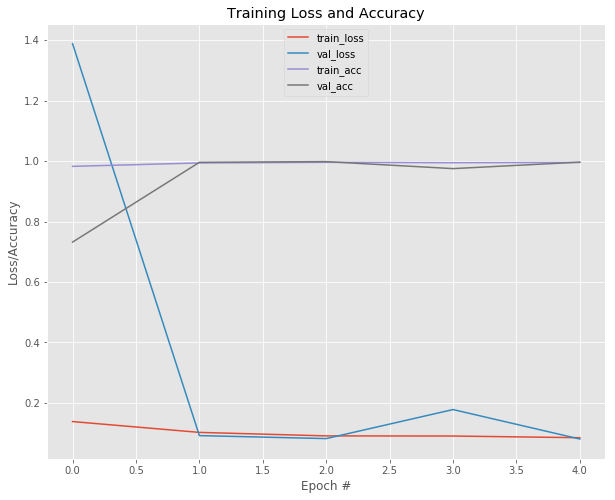

In [24]:
plot_training(H, 5)

### Inference on the test set and submission

In [ ]:
# get the predictions from the network and map 
# the class-labels accordingly
predIdxs = model.predict_generator(testGen,
    steps=(sub_file.shape[0] // 64) + 1)
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
sub_file.has_cactus = predIdxs
sub_file.to_csv('submission.csv', index=False)

### References:
- [TensorFlow Hub with Keras](https://www.tensorflow.org/beta/tutorials/images/hub_with_keras)
- [Fine-tuning with Keras and Deep Learning](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)